In [2]:
%load_ext autoreload
%autoreload 2
import sklearn
from sklearn.datasets import load_wine, load_iris
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

from convexlocalisometry.transformation import exponential_transformation
from convexlocalisometry.loss import isometry_loss
from convexlocalisometry.algorithm import greedy, brute, group_basis_pursuit, group_lasso
import random

np.random.seed(1234)
random.seed(1234)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
wine = load_wine()
print(wine.keys())
P_wine, D_wine = wine['data'].shape
print("D_wine", D_wine)
print("P_wine", P_wine)
print(wine['feature_names'])
wine_df = pd.DataFrame(data= wine['data'], columns = wine['feature_names']) # label with class names?
scaler = StandardScaler()
wine_standardized = pd.DataFrame(data = scaler.fit_transform(wine['data']), columns = wine['feature_names'])
# wine_standardized = pd.DataFrame(data = wine['data'], columns = wine['feature_names'])

iris = load_iris()
print(iris.keys())
P_iris, D_iris = iris['data'].shape

print("D_iris", D_iris)
print("P_iris", P_iris)
print(wine['feature_names'])
iris_df = pd.DataFrame(data= iris['data'], columns = iris['feature_names'])

scaler = StandardScaler()
iris_standardized = pd.DataFrame(data = scaler.fit_transform(iris['data']), columns = iris['feature_names'])
# iris_standardized = pd.DataFrame(data = iris['data'], columns = iris['feature_names'])


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
D_wine 13
P_wine 178
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
D_iris 4
P_iris 150
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [72]:
iris_standardized = pd.DataFrame(data = scaler.fit_transform(iris['data']), columns = iris['feature_names'])
np.linalg.norm(iris_standardized, axis = 1)

array([2.31866282, 2.20238668, 2.38940142, 2.37838853, 2.47614211,
       2.55473374, 2.46767902, 2.24585711, 2.59157687, 2.24883352,
       2.41964028, 2.33563766, 2.34644821, 2.80905161, 2.92503479,
       3.51243853, 2.66649972, 2.2466007 , 2.39217872, 2.60431164,
       2.00234918, 2.39875277, 2.83157138, 1.82726905, 2.25077619,
       2.07277996, 2.06830957, 2.24131482, 2.18093082, 2.29387891,
       2.20059821, 1.91440521, 3.17956706, 3.25861518, 2.16647538,
       2.23523023, 2.21215174, 2.59946698, 2.59963424, 2.19338215,
       2.33146824, 3.0069688 , 2.61697065, 2.051673  , 2.44054138,
       2.19390064, 2.6398415 , 2.4298273 , 2.44939137, 2.20971092,
       1.55836927, 0.94726134, 1.49226836, 1.8024525 , 1.17032578,
       0.75926713, 1.08767802, 1.93203314, 1.10378923, 1.16642486,
       2.65680719, 0.49181538, 2.0046733 , 0.76441113, 0.49368691,
       1.13579081, 0.66245509, 0.886572  , 2.10147026, 1.32534422,
       1.04330514, 0.69577521, 1.59063478, 0.85690627, 0.83581

In [73]:
iris_standardized = pd.DataFrame(data = iris['data'], columns = iris['feature_names'])
np.linalg.norm(iris_standardized, axis = 1)

array([ 6.34507683,  5.91692488,  5.83609458,  5.7497826 ,  6.32139225,
        6.88621812,  5.8966092 ,  6.23297682,  5.45618915,  5.98999165,
        6.71863081,  6.09918027,  5.83180932,  5.35817133,  7.14982517,
        7.36613874,  6.79852925,  6.34901567,  7.06470098,  6.54140658,
        6.60681466,  6.48922183,  5.92958683,  6.32771681,  6.18465844,
        6.04979338,  6.26737585,  6.44825558,  6.37181293,  5.91016074,
        5.93717104,  6.56734345,  6.79043445,  7.06328535,  5.99249531,
        6.05970296,  6.65056389,  6.2401923 ,  5.48543526,  6.31347765,
        6.24739946,  5.22685374,  5.59732079,  6.33798075,  6.64981203,
        5.83866423,  6.56124988,  5.77927331,  6.63852393,  6.15548536,
        9.12633552,  8.58487041,  9.13673902,  7.29588925,  8.5732141 ,
        7.89113427,  8.67352293,  6.45445583,  8.64985549,  7.17635005,
        6.5       ,  7.98122798,  7.60526134,  8.3468557 ,  7.37699126,
        8.70746806,  7.92842986,  7.6642025 ,  8.11048704,  7.35

In [105]:
??isometry_loss
power = .33
isometry_loss_power = lambda x : isometry_loss(x, power)

In [106]:
losses = []
nbp = []
two_stage_losses = []
random_two_stage_losses= []
D_iris =4
for i in range(25):
    X = iris_standardized.sample(frac = .5).to_numpy().transpose()
#     X = iris_standardized.sample(axis = 1, frac = .5).to_numpy()
# TODO (Sam): enable c in greedy / isometry_loss
    output = greedy(X, isometry_loss_power, D_iris, []) # plainly brute is too hard 178**13 combinations
    loss = isometry_loss_power(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X, power = power)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    nbp.append(len(basis_pursuit_indices))
    #     two_stage_output = basis_pursuit_indices[np.asarray(greedy(X[:,basis_pursuit_indices], isometry_loss, D_wine, []))] # plainly this is too hard 178**13 combinations
    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss_power, D_iris))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss_power(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss_power(X[:,random_indices]))

Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19910.57it/s]
/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 25045.61it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21732.15it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 12985.46it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 19636.25it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 4332.96it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19295.56it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 20725.77it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 16309.37it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 17672.63it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 4100.00it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19104.72it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 20831.65it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 25745.46it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 20493.34it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 23849.34it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19032.88it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9882.90it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 8992.93it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21590.45it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 22381.56it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 1736.05it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 16431.07it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21254.92it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19487.67it/s]


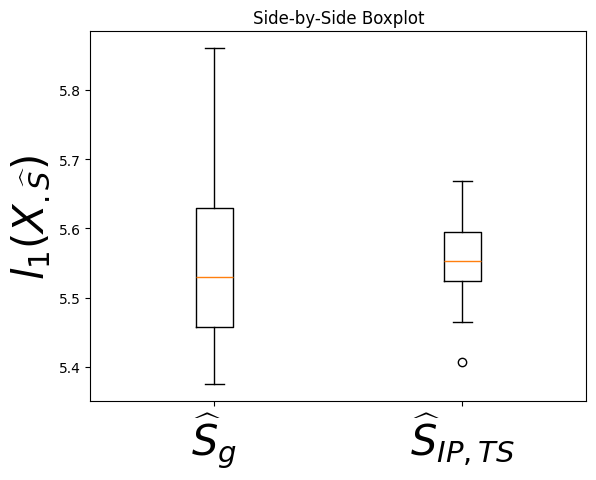

In [107]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

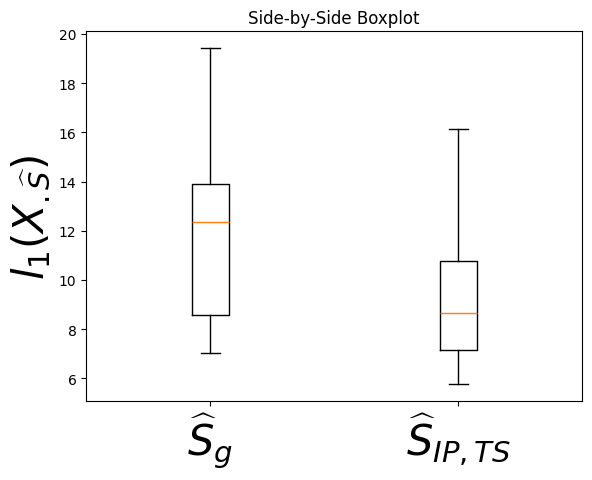

In [65]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

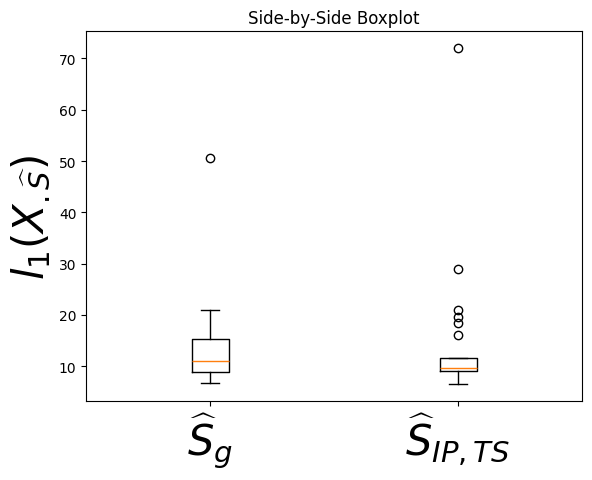

In [67]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

In [108]:
losses = []
two_stage_losses = []
nbp = []
random_two_stage_losses= []
dimension = 6
for i in range(25):
    X = wine_standardized.sample(frac = .5).to_numpy().transpose()[:dimension,:]
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
#     output = brute(X, isometry_loss, dimension)
    loss = isometry_loss(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    nbp.append(len(basis_pursuit_indices))

    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss, dimension))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss(X[:,random_indices]))

/Users/samsonkoelle/convexlocalisometry/convexlocalisometry/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 25575.41it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25010.17it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26647.15it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28273.74it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 27329.76it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 6


5005it [00:00, 28233.44it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 24943.75it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28037.82it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 6


5005it [00:00, 27373.96it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28663.88it/s]


Computing brute force solution for dictionary dimension 11 and target_dimension 6


462it [00:00, 25412.69it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 24537.88it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28848.40it/s]


Computing brute force solution for dictionary dimension 13 and target_dimension 6


1716it [00:00, 27664.96it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 27724.48it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 26225.40it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26005.43it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26490.34it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 6


12376it [00:00, 28938.86it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25231.66it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 6


12376it [00:00, 26509.69it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25806.95it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 23966.31it/s]


Computing brute force solution for dictionary dimension 13 and target_dimension 6


1716it [00:00, 27196.63it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 25533.41it/s]


In [110]:
??greedy

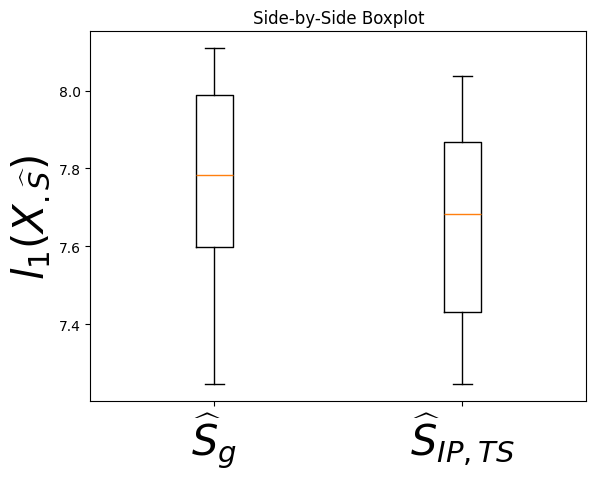

In [109]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

In [8]:
print(np.mean(losses))
print(np.std(losses))  # Standard deviation
print(np.mean(two_stage_losses))
print(np.std(two_stage_losses))  # Standard deviation
print(np.mean(nbp))
print(np.std(nbp))  # Standard deviation

5.734369034010522
0.18991729870508334
5.618834928412273
0.12878299514658612
11.48
1.389100428334827


In [128]:
def greedy(matrix, loss, target_dimension=None, selected_indices=[]):
    """Matrix is d \times p dimensional"""
    if target_dimension is None:
        target_dimension, dictionary_dimension = (
            matrix.shape
        )  # NOTE (Sam): this won't hold necessarily for regression in ambient space instead of tangent space.
    else:
        dictionary_dimension = matrix.shape[1]

    while len(selected_indices) < target_dimension:
        # if target_dimension > 0:
        candidate_losses = np.repeat(np.nan, dictionary_dimension)
        dictionary_indices = list(range(dictionary_dimension))
        random.shuffle(dictionary_indices)
        print(dictionary_indices)
        for p in dictionary_indices:
            if p not in selected_indices:
                candidate_parametrization = np.concatenate(
                    [selected_indices, [p]]
                ).astype(int)
                candidate_losses[p] = loss(matrix[:, candidate_parametrization])
        most_isometric_index = np.nanargmin(candidate_losses)
        selected_indices.append(most_isometric_index)
        selected_indices = greedy(
            matrix, loss, target_dimension, selected_indices=selected_indices
        )

    return selected_indices

In [136]:
losses = []
X = wine_standardized.sample(frac = .5).to_numpy().transpose()[:dimension,:]
for a in range(25):
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
    print(output)
    loss = isometry_loss(X[:,output])
    losses.append(loss)

[63, 28, 27, 25, 11, 37, 66, 59, 29, 72, 62, 71, 84, 53, 78, 67, 32, 10, 36, 44, 20, 22, 70, 13, 9, 8, 55, 69, 6, 31, 43, 3, 73, 15, 85, 0, 41, 45, 52, 5, 23, 57, 40, 76, 81, 12, 18, 61, 26, 54, 7, 4, 56, 2, 1, 58, 24, 16, 50, 87, 86, 88, 49, 38, 33, 75, 74, 34, 47, 35, 39, 82, 64, 68, 30, 21, 46, 14, 79, 42, 60, 77, 48, 65, 17, 80, 19, 83, 51]
[37, 32, 20, 22, 29, 40, 0, 82, 55, 70, 63, 11, 30, 52, 13, 2, 66, 69, 1, 64, 10, 43, 59, 81, 49, 27, 61, 62, 78, 26, 60, 35, 33, 45, 56, 47, 28, 54, 36, 77, 83, 67, 44, 73, 15, 72, 75, 53, 68, 51, 21, 12, 65, 76, 24, 34, 3, 87, 16, 80, 31, 46, 18, 86, 57, 38, 79, 41, 9, 84, 25, 14, 50, 74, 17, 4, 85, 23, 58, 6, 5, 8, 71, 88, 42, 19, 39, 7, 48]
[27, 44, 64, 32, 35, 87, 81, 17, 24, 39, 48, 11, 55, 23, 0, 80, 34, 75, 1, 40, 45, 4, 60, 56, 78, 22, 43, 28, 33, 41, 18, 88, 82, 30, 46, 29, 74, 69, 58, 21, 36, 2, 65, 10, 51, 25, 63, 70, 9, 49, 38, 13, 86, 85, 42, 84, 83, 3, 7, 8, 16, 71, 67, 76, 73, 66, 57, 54, 15, 31, 79, 37, 50, 72, 61, 19, 77, 26, 1

[55, 18, 25, 11, 37, 43, 67, 22, 9, 78, 24, 36, 1, 85, 69, 68, 62, 57, 65, 81, 52, 26, 53, 13, 50, 6, 30, 77, 84, 40, 20, 58, 23, 32, 5, 61, 73, 66, 31, 48, 75, 41, 79, 83, 46, 80, 33, 16, 17, 70, 10, 34, 59, 8, 42, 14, 7, 21, 39, 56, 45, 12, 60, 63, 47, 44, 74, 3, 15, 54, 2, 86, 35, 28, 4, 51, 82, 0, 88, 72, 64, 71, 87, 27, 76, 38, 49, 29, 19]
[33, 35, 20, 46, 54, 87, 62, 37, 11, 45, 14, 50, 84, 42, 3, 47, 4, 19, 36, 31, 25, 24, 22, 0, 48, 21, 58, 79, 88, 28, 41, 40, 75, 43, 76, 12, 18, 57, 65, 29, 85, 51, 53, 70, 23, 74, 1, 44, 27, 13, 9, 49, 86, 15, 69, 16, 77, 63, 26, 78, 32, 72, 83, 60, 5, 39, 10, 73, 59, 17, 30, 34, 81, 66, 38, 8, 80, 52, 64, 71, 7, 82, 2, 56, 6, 61, 55, 68, 67]
[31, 59, 86, 33, 73, 74, 77, 11, 18, 65, 68, 25, 16, 13, 32, 53, 78, 35, 55, 85, 63, 87, 12, 47, 49, 44, 58, 19, 15, 52, 4, 28, 66, 27, 37, 34, 10, 62, 46, 54, 17, 80, 41, 5, 9, 70, 38, 57, 67, 48, 0, 21, 3, 71, 40, 7, 6, 36, 84, 14, 56, 76, 43, 83, 39, 45, 79, 26, 23, 8, 61, 69, 2, 20, 82, 24, 51, 72, 29

[32, 75, 80, 67, 54, 60]


In [138]:
losses

[7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095,
 7.9967449359834095]

In [111]:
import random


In [115]:
q = list(range(10))

In [116]:
random.shuffle(q)

In [117]:
q

[8, 7, 4, 3, 6, 0, 5, 9, 1, 2]